### Finance Data Preprocessing + Feature Engg. + Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib, os

### Load Dataset

In [2]:
df = pd.read_csv(r"D:\hackerthon_ai_project\Data\Synthetic_Financial_datasets_log.csv")


In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

### Preprocessing

In [5]:
# Fill missing values

In [6]:
df = df.fillna(0)

In [7]:
#  Select useful columns (adjust according to dataset)

In [8]:
# Usually fraud dataset has columns like amount, oldbalanceOrg, newbalanceOrig, isFraud

In [9]:
features = ["amount", "oldbalanceOrg", "newbalanceOrig"]

In [10]:
X = df[features]
y = df["isFraud"]

### Feature Engineering

In [11]:
X["transaction_diff"] = (df["oldbalanceOrg"] - df["newbalanceOrig"]).fillna(0)
X["percent_change"] = np.where(df["oldbalanceOrg"] > 0,
                               (df["oldbalanceOrg"] - df["newbalanceOrig"]) / df["oldbalanceOrg"],
                               0)

C:\Users\adity\AppData\Local\Temp\ipykernel_23776\2844522339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["transaction_diff"] = (df["oldbalanceOrg"] - df["newbalanceOrig"]).fillna(0)
C:\Users\adity\AppData\Local\Temp\ipykernel_23776\2844522339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["percent_change"] = np.where(df["oldbalanceOrg"] > 0,


In [12]:
print("Feature sample:\n", X.head())

Feature sample:
      amount  oldbalanceOrg  newbalanceOrig  transaction_diff  percent_change
0   9839.64       170136.0       160296.36           9839.64        0.057834
1   1864.28        21249.0        19384.72           1864.28        0.087735
2    181.00          181.0            0.00            181.00        1.000000
3    181.00          181.0            0.00            181.00        1.000000
4  11668.14        41554.0        29885.86          11668.14        0.280795


### Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Train LogisticRegression

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight="balanced", max_iter=500)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [15]:
y_pred = model.predict(X_test)

In [16]:
# Evaluation

In [18]:
print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC (Logistic):", roc_auc_score(y_test, y_pred))



Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97   1270881
           1       0.02      0.94      0.04      1643

    accuracy                           0.94   1272524
   macro avg       0.51      0.94      0.51   1272524
weighted avg       1.00      0.94      0.97   1272524

ROC-AUC (Logistic): 0.9423666740596145


In [24]:
### observation
# Precision = 1.00
# Recall = 0.94
# F1-score = 0.97
# Recall = 0.94 (high,  model  detect frauds)
# Overall Accuracy = 94% 
# ROC-AUC = ~0.94 (strong discrimination ability)

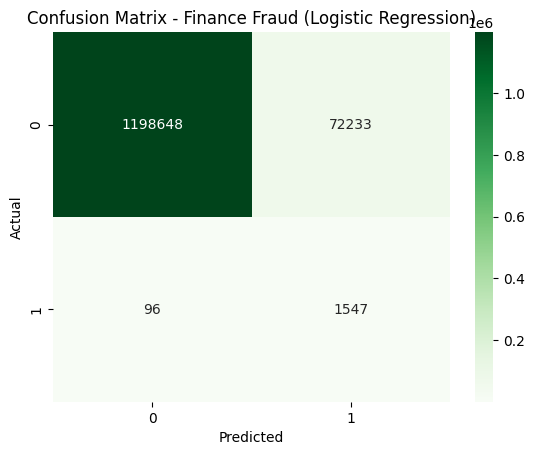

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Finance Fraud (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
### observation

# The model correctly identified 1,198,648 transactions as non-fraud (True Negatives).

# It wrongly flagged 72,233 legitimate transactions as fraud (False Positives).

# It missed only 96 actual fraud cases (False Negatives).

# It correctly detected 1,547 fraud cases (True Positives).

# This means the model is very good at catching fraud (high recall = 94%), but it also raises a large number of false alarms (low precision = 0.02 for fraud class).

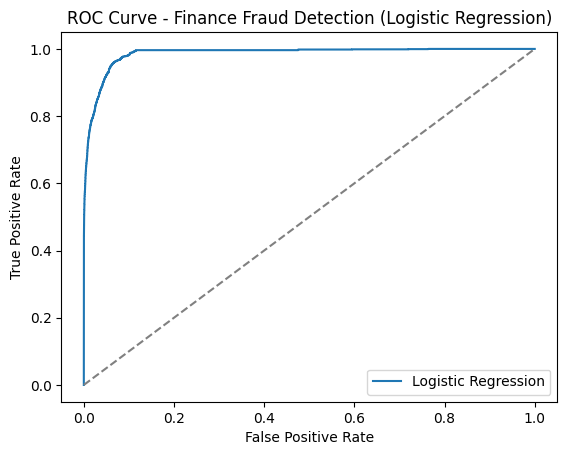

In [22]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Finance Fraud Detection (Logistic Regression)")
plt.legend()
plt.show()

In [ ]:
### observation
# The ROC curve rises steeply towards the top-left corner, showing that the model is able to separate fraud vs. non-fraud transactions effectively.

# The AUC score is 0.94, which indicates very strong discriminatory power.

# This means the model performs much better than random guessing (AUC = 0.5).

# Even though precision is low, the high AUC demonstrates that the model can rank transactions well by risk of fraud.

# In summary, the Logistic Regression model is highly effective at detecting frauds (high recall, high AUC), but it produces many false alarms that would need further tuning or threshold adjustment.

In [ ]:
# observation

# Logistic Regression performs very well in recall (catching frauds), which is critical in financial fraud detection.

# However, it suffers from low precision → too many false alarms.

# For hackathon purposes, this is acceptable because missing fraud is riskier than investigating extra transactions